Model Performance Testing...
Model loading...
Model loading success!
Prediction start...
Background removal begins! Now :1/1
Trying to open an image and express it in form of ndarray...
Image open success! Now confirm the coordinate of image...
Image preprocessing...
Current prediction progress： 100%
Background removal is done!
Total time cost: 3.6624 s
Image saving...
ok!


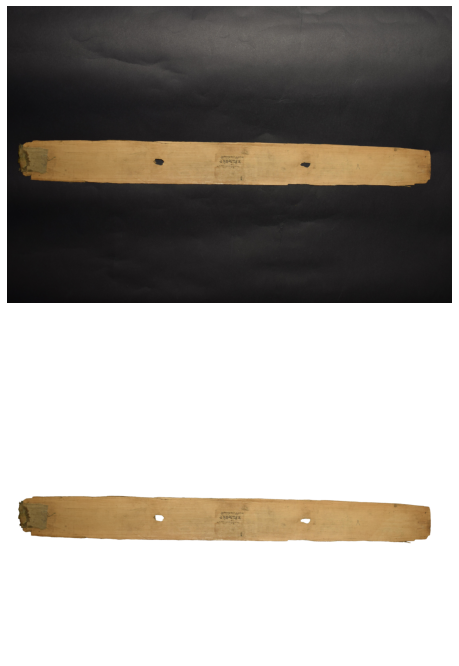

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 17 10:24:33 2021

@author: BMZN109K32G10GPU-03
"""

import torch
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import cv2
# 自定义类
from unet import UNet, UNet1, UNet_4l

import PIL.Image as Image
import matplotlib.pyplot as plt

def byj_position_detection(src):
    '''
    this function is used for preprocessing the palm-leaf manuscript images.
    the position of the manuscript is firstly detected, and the image of 
    palm-leaf manuscript is then cropped to balance the ratio of the subject,
    namely the palm-leaf manuscript and the background.

    Parameters
    ----------
    src : ndarray
        a 3-D array indicating the image of palm-leaf manuscript.
        the former two dimension jointly indicates the size of the image.
        the last one dimension indicates the channels of the image, for a
        digital image, it is 3 channels that the last one dimension is, which 
        are respectively red channel, green channel and blue channel.

    Returns
    -------
    [row_min, row_max, col_min, col_max] : list
        row_min : the minimum coordinate value of row
        row_max : the maximum coordinate value of row
        col_min : the minimum coordinate value of cloumn
        col_max : the maximum coordinate value of cloumn

    '''
    # Canny Edge Extraction Parameters
    init_threhold = 80
    canny_up = 130
    canny_down = 80
    kernel_size = (6, 4)
    
    # Open the pic and make it a matrix
    # src = np.array(Image.open(file_path).convert('RGB'))
    if src.shape[0] > src.shape[1]:
        src = np.transpose(src,(1,0,2))
    
    length = src.shape[1] #big
    width = src.shape[0]
    # Make use of OpenCV to transform RGB mode to HSV mode
    hsv_ori = cv2.cvtColor(src, cv2.COLOR_RGB2HSV)
    
    # blank = np.zeros_like(ori, ori.dtype)
    b, g, r = cv2.split(hsv_ori)
    r[r < init_threhold] = 255
    r = cv2.GaussianBlur(r, (5, 5), 0)
    
    # -- Edge detection -------------------------------------------------------------------
    edges = cv2.Canny(r, canny_down, canny_up)
    KERNEL = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    edges = cv2.dilate(edges, KERNEL, iterations=1)
    edges = cv2.erode(edges, KERNEL, iterations=1)
    
    # -- Find contours in edges, sort by area ---------------------------------------------
    contour_info = []
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for c in contours:
        contour_info.append((c, cv2.isContourConvex(c), cv2.contourArea(c)))
    contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
    max_contour = contour_info[0][0]
    
    # Get the maximun coordinate of the contour
    max_contour_coordinate = max_contour[:,0,:]
    col_max = np.max(max_contour_coordinate[:,0]) + 100
    col_min = np.min(max_contour_coordinate[:,0]) - 100
    row_max = np.max(max_contour_coordinate[:,1]) + 100
    row_min = np.min(max_contour_coordinate[:,1]) - 100
    
    # Threhold Setting to avoid being out of range
    if col_max > length:
        col_max = length - 1
    if row_max > width:
        row_max = width - 1
    if col_min < 0:
        col_min = 0
    if row_min < 0:
        row_min = 0
    
    return [row_min, row_max, col_min, col_max]


print("Model Performance Testing...")
#print("Current index of model is {}".format(ind))
print("Model loading...")
device = torch.device("cuda:0")
model = UNet(3, 2).to(device)
model.load_state_dict(torch.load("D:/beijingkouchu/MY_Unet/total70_model_5l_nomax_12_250_wd1e5_max.pkl", map_location=device))
model.eval()
print("Model loading success!")
print("Prediction start...")

filepath = "D:/beijingkouchu/BG1FORGIT"
dirs = os.listdir(filepath)

import time
t1 = time.time()
for ind, dir_ in enumerate(dirs):
    ass = []
    # open an image
    print("Background removal begins! Now :{}/{}".format(ind+1, len(dirs)))
    print("Trying to open an image and express it in form of ndarray...")
    data_x1 = np.array(Image.open(filepath + "\\" + dir_ + "\\img.png").convert('RGB'))
    fig = plt.figure(figsize=(10,12))
    ax1 = fig.add_subplot(211)
    ax1.set_axis_off()
    ax2 = fig.add_subplot(212)
    ax2.set_axis_off()
    ax1.imshow(data_x1)
    
    print("Image open success! Now confirm the coordinate of image...")
    [row_min, row_max, col_min, col_max] = byj_position_detection(data_x1)
    
    print("Image preprocessing...")
    data_x = np.transpose(data_x1,(2,0,1))
    if data_x.shape[1] > data_x.shape[2]:
        data_x = np.transpose(data_x,(0,2,1))
        
    length = data_x.shape[2]
    width = data_x.shape[1]
    
    max_col_factor = length // 400 + 1
    
    # after position detection, the distance of the position coordinate
    row_length = row_max - row_min
    col_length = col_max - col_min
    
    # if supplying it to the beishu of 512/400
    row_factor = row_length // 512 + 1
    col_factor = col_length // 400 + 1
    row = row_factor * 512
    col = col_factor * 400
    
    # supply
    supplyment_row = row - row_length
    supplyment_col = col - col_length
    
    nrow_min = row_min - (supplyment_row)//2
    nrow_max = row_max + supplyment_row - (supplyment_row)//2
    ncol_min = col_min - (supplyment_col)//2
    ncol_max = col_max + supplyment_col - (supplyment_col)//2
    
    if col_factor == max_col_factor:
        ncol_min = 0
        ncol_max = length
    elif ncol_min < 0:
        ncol_min = 0
        ncol_max = 400 * col_factor
    elif ncol_max > length:
        ncol_max = length
        ncol_min = length - 400 * col_factor
    
    data_x = data_x.astype(np.float32)
    
    data_xs = data_x[:, nrow_min:nrow_max, ncol_min:ncol_max]
    # print(data_xs.shape)
    blank = np.zeros((data_xs.shape[1],data_xs.shape[2]))
    
    bar = 0
    total = row_factor * col_factor
    for i in range(row_factor):
        for ii in range(col_factor):
            bar += 1
            test_x = data_xs[:,(512*i):(512*(i+1)),(400*ii):(400*(ii+1))]
            with torch.no_grad():
                test_x = test_x.reshape((1, 3, 512, 400))
                test_x = test_x / test_x.max()
                test_x = torch.from_numpy(test_x)
                test_x = test_x.to(device)
                pred_y = model(test_x) 
                
                py = pred_y.cpu().numpy()
                py = py.reshape(2,512,400)        
                a = np.argmax(py, axis=0)
                ass.append(a)
                blank[(512*i):(512*(i+1)),(400*ii):(400*(ii+1))] = a

                per = bar / total 
                print("\rCurrent prediction progress： %.f%s" % (per*100, '%'), flush=True, end='')
                
    print()
    blank = blank.astype(np.uint8)
    contours, _ = cv2.findContours(blank, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    for contour in contours:
        if len(contour[:,0,:]) < 150:
            c_edges = contour[:,0,:]
            cmin = np.min(c_edges[:,0]) - 1
            cmax = np.max(c_edges[:,0]) + 1
            rmin = np.min(c_edges[:,1]) - 1
            rmax = np.max(c_edges[:,1]) + 1
            if cmax >= data_xs.shape[2]:
                cmax = data_xs.shape[2]-1
            if rmax >= data_xs.shape[1]:
                rmax = data_xs.shape[1]-1
            if cmin < 0:
                cmin = 0
            if rmin < 0:
                rmin = 0
            
            byj_or_br = []
            byj_or_br.append(blank[rmin,cmin])
            byj_or_br.append(blank[rmin,cmax])
            byj_or_br.append(blank[rmax,cmin])
            byj_or_br.append(blank[rmax,cmax])
            if len(np.where(np.array(byj_or_br)==1)[0]) >= 2:
                blank[rmin:rmax,cmin:cmax] = 1
            else:
                blank[rmin:rmax,cmin:cmax] = 0
                
    # import cv2
    # ori = np.transpose(data_xs,(1,2,0))
    # result = cv2.bitwise_and(ori, ori, blank)
    # result[blank == 0] = 255  # white background
    # result = result.astype('uint8')
    # result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
    # os.chdir("D:\\beijingkouchu\\BG9BR_1")
    # cv2.imwrite("{}_bg9_5l_nomax_trans.png".format(ind),result)
    # print("ok!")

    t2 = time.time()
    print("Background removal is done!")
    print("Total time cost: %.4f s"%(t2-t1))
    
    
    print("Image saving...")
    new_ori = np.array(Image.open(filepath + "\\" + dir_ + "\\img.png").convert('RGB'))
    if new_ori.shape[0] > new_ori.shape[1]:
        new_ori = np.transpose(new_ori,(1,0,2))
    new_blank = np.zeros((new_ori.shape[0],new_ori.shape[1]))
    new_blank[nrow_min:nrow_max, ncol_min:ncol_max] = blank
    new_result = cv2.bitwise_and(new_ori, new_ori, new_blank)
    new_result[new_blank == 0] = 255  # white background
    new_result = new_result.astype('uint8')
    ax2.imshow(new_result)
    new_result = cv2.cvtColor(new_result, cv2.COLOR_RGB2BGR)
    os.chdir("D:/beijingkouchu/BG1FORGITR")
    cv2.imwrite("{}_filename.png".format(ind),new_result)
    print("ok!")